<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis/blob/main/alldata/Replicate_GCP1_main_conclusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount Google drive to download the data some

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
%cd /content/drive/MyDrive/GCP_data/all_data
#data at https://drive.google.com/drive/u/0/folders/1MUS-xbwoBiodWLz4gese19ti_ftlKsVu

/content/drive/MyDrive/GCP_data/all_data


In [3]:
#install some utilities code at https://github.com/AvantiShri/gcpdatautils
!pip uninstall -y gcpdatautils #uninstall the pre-existing version if want to fetch latest
!pip install git+https://github.com/AvantiShri/gcpdatautils.git #install latest from github

#Note: the code that was used to consolidate the csv.gz files as hdf5 files
# is at https://github.com/AvantiShri/gcp_analysis/blob/main/alldata/Consolidate_GCP_as_HDF5.ipynb

  Cloning https://github.com/AvantiShri/gcpdatautils.git to /tmp/pip-req-build-etgkm7cq
  Running command git clone --filter=blob:none --quiet https://github.com/AvantiShri/gcpdatautils.git /tmp/pip-req-build-etgkm7cq
  Resolved https://github.com/AvantiShri/gcpdatautils.git to commit 6274642ab27e5539a77b452079749596450731d1
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for gcpdatautils: filename=gcpdatautils-0.1.0.0-py3-none-any.whl size=6118 sha256=f0c0b028c9801572e7a47c6bb7ae4146917c2b11ae9e323d7b3b4c9451bbd4d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-hru1alyx/wheels/fe/f9/b7/d5afa50c9e111dcf3a66edb57f0c2273e54d108591664596b8
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1256 sha256=0bb3b1c9095be67b7e4577f9b9ffd66bda75cdd75ed3ad70f62660ebaaff4705
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built gcpdatautils bs4


Load in the GCP events

In [4]:
from gcpdatautils import parse_events_html

#download the formal event registry and read the events in
!wget https://global-mind.org/pred_formal.html -O pred_formal.html

# we will parse the events file, dropping events longer than 30 days for memory efficiency
# we will also drop 'New Year Var...' events as they tend to be redundant in duration
# with the 'mean' events, and we are going to do a standard analysis on all the events
included_events = parse_events_html("/content/drive/MyDrive/GCP_data/pred_formal.html",
                                    exclude_events_longer_than_days=30)

--2024-01-05 06:48:24--  https://global-mind.org/pred_formal.html
Resolving global-mind.org (global-mind.org)... 162.245.217.130
Connecting to global-mind.org (global-mind.org)|162.245.217.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘pred_formal.html’

pred_formal.html        [ <=>                ] 184.64K  --.-KB/s    in 0.1s    

2024-01-05 06:48:24 (1.75 MB/s) - ‘pred_formal.html’ saved [189067]

Skipping because redundant with a corresponding 'mean' event:  43 New Year Var 99-00 1999-12-31 09:30:00 2000-01-01 11:29:59
Skipping because redundant with a corresponding 'mean' event:  65 New Year Var 00-01 2000-12-31 09:30:00 2001-01-01 11:29:59
Skipping because redundant with a corresponding 'mean' event:  98 New Year Var 01-02 2001-12-31 09:30:00 2002-01-01 11:29:59
Skipping because redundant with a corresponding 'mean' event:  126 New Year Variance 2002-12-31 09:30:00 2003-01-01 11:29:59
Skipping because redundant w

In [5]:
len(included_events)

495

Define the code for reading from the hdf5 files

In [13]:
import numpy as np
from collections import defaultdict
import h5py
from datetime import datetime, timedelta
from gcpdatautils import ROTTEN_EGGS, parse_rotten_egg_file

class GCPMissingDataError(RuntimeError):
  pass

class GCPHdf5DataReader(object):

  def __init__(self, bad_data_file=ROTTEN_EGGS,
                     year_to_hdf5path=lambda x: "GCP1data_"+str(x)+".hdf5"):
    print("Parsing the bad data file:",bad_data_file)
    #reorganize the bad data list by device ID
    self.bad_data_lookup = defaultdict(list)
    for baddata_starttime, baddata_endtime, deviceid in parse_rotten_egg_file(bad_data_file):
      self.bad_data_lookup[deviceid].append((baddata_starttime, baddata_endtime))
    self.year_to_hdf5fh = {} #mapping from the year to the hdf5 file handle
    self.year_to_hdf5path = year_to_hdf5path

  def fetch_data(self, starttime, endtime, normalize=False):

    if (endtime.strftime("%Y-%m-%d") == starttime.strftime("%Y-%m-%d")):
      return self.fetch_data_within_day_normalize(starttime, endtime, normalize=normalize) #returns both data and devices
    else:
      #split into accesses over multiple days
      start_day = starttime.strftime("%Y-%m-%d")
      end_day = endtime.strftime("%Y-%m-%d")
      #for the first day:
      day_accesses = [ (
          starttime,
          datetime.strptime(start_day+" 23:59:59", '%Y-%m-%d %H:%M:%S')) ]
      #for intermediate days:
      dayoffset = 1
      inter_day = (starttime + timedelta(days=dayoffset)).strftime("%Y-%m-%d")
      while inter_day != end_day:
        day_accesses.append(
            (datetime.strptime(inter_day+" 00:00:00", '%Y-%m-%d %H:%M:%S'),
             datetime.strptime(inter_day+" 23:59:59", '%Y-%m-%d %H:%M:%S')))
        dayoffset += 1
        inter_day = (starttime + timedelta(days=dayoffset)).strftime("%Y-%m-%d")

      #for the final day
      day_accesses.append(
          (datetime.strptime(inter_day+" 00:00:00", '%Y-%m-%d %H:%M:%S'),
           endtime))
      days_data_and_devices = [self.fetch_data_within_day_normalize(t1, t2, normalize=normalize) for (t1,t2) in day_accesses]
      #if all the days have the same sets of devices...
      if (len(set([str(x[1]) for x in days_data_and_devices]))==1):
        return np.concatenate([x[0] for x in days_data_and_devices], axis=0), days_data_and_devices[0][1]
      else:
        #print("Some days don't have same devices. Rearranging")
        all_devices = set()
        [all_devices.update(x[1]) for x in days_data_and_devices]
        all_devices = sorted(all_devices)
        all_devices_newidxs = dict([(x[1],x[0]) for x in enumerate(all_devices)])
        rearranged_days_data = []
        for day_data, day_devices in days_data_and_devices:
          rearranged_day_data = np.zeros((len(day_data), len(all_devices)))
          rearranged_day_data[:,:] = np.nan
          for orig_deviceidx, deviceid in enumerate(day_devices):
            rearranged_day_data[:,all_devices_newidxs[deviceid]] = day_data[:,orig_deviceidx]
          rearranged_days_data.append(rearranged_day_data)
        return np.concatenate(rearranged_days_data, axis=0), all_devices

  def fetch_data_within_day_normalize(self, starttime, endtime, normalize):
    if (normalize==False):
      return self.fetch_data_within_day(starttime, endtime)
    else:
      day = starttime.strftime("%Y-%m-%d")
      day_start = datetime.strptime(day+" 00:00:00", '%Y-%m-%d %H:%M:%S')
      day_end = datetime.strptime(day+" 23:59:59", '%Y-%m-%d %H:%M:%S')
      full_day_data, daydevices = self.fetch_data_within_day(day_start, day_end)
      #set ddof=1 to get unbiased (more conservative) stdev estimates
      device_day_stdevs = np.nan_to_num(np.nanstd(full_day_data, axis=0, ddof=1), np.sqrt(50))
      device_day_means = np.nan_to_num(np.nanmean(full_day_data, axis=0), 100)
      #transform the data to be centered around 100, with stdev of sqrt(50)
      full_day_data_normalized = ((full_day_data - device_day_means[None,:])/
                                  (device_day_stdevs[None,:]/np.sqrt(50))) + 100
      start_offset =  int(starttime.timestamp() - day_start.timestamp())
      end_offset = int((endtime.timestamp() - day_start.timestamp()) + 1)
      return full_day_data_normalized[start_offset:end_offset], daydevices

  def get_fh_for_year(self, year):
    if (year not in self.year_to_hdf5fh):
      self.year_to_hdf5fh[year] = h5py.File(self.year_to_hdf5path(year), "r")
    return self.year_to_hdf5fh[year]

  def get_available_days_in_year(self, year):
    fh = self.get_fh_for_year(year)
    return fh.keys()

  def fetch_data_within_day(self, starttime, endtime):
    assert endtime.strftime("%Y-%m-%d") == starttime.strftime("%Y-%m-%d")
    year = starttime.year
    fh = self.get_fh_for_year(year)
    day = starttime.strftime("%Y-%m-%d")
    if (day not in fh):
      raise GCPMissingDataError("data for "+day+" not present")
    dset = fh[day]
    if dset.attrs['start_time'] > starttime.timestamp():
      raise GCPMissingDataError("query for day "
             +day+" starts at "+str(starttime.timestamp())
             +" but data for day starts at "+str(dset.attrs['start_time']))
    if dset.attrs['end_time'] < endtime.timestamp():
      raise GCPMissingDataError("query for day "
             +day+" ends at "+str(endtime.timestamp())
             +" but data for day ends at "+str(dset.attrs['end_time']))
    #now that we have verified that the day has all the data we need...
    start_offset = int(starttime.timestamp() - dset.attrs['start_time'])
    end_offset = int(endtime.timestamp()+1 - dset.attrs['start_time']) #add +1 since GCP ranges are end-inclusive
    day_data = np.array(dset[start_offset:end_offset]).astype("float")
    #replace 255 with nan; 255 was used to encode NaNs in the hdf5 file
    day_data[day_data==255] = np.nan
    #Radin 2023 (Anomalous entropic effects in physical systems associated
    # with collective consciousness) said "All individual samples within a matrix
    # less than 55 or greater than 145 were set to nan" so we do that here
    day_data = np.where((day_data < 55), np.nan, day_data)
    day_data = np.where((day_data > 145), np.nan, day_data)

    #Mask out columns with bad data
    masking_occurred = False
    devices_on_day = fh[day].attrs["device_ids"]
    for deviceid_idx,deviceid in enumerate(devices_on_day):
      if (deviceid in self.bad_data_lookup):
        for rottenegg_start, rottenegg_end in self.bad_data_lookup[deviceid]:
          if (rottenegg_start.timestamp() <= endtime.timestamp() and rottenegg_end.timestamp() >= starttime.timestamp()):
            if (masking_occurred == False):
              print("Before masking, fraction of nans in raw data is", np.mean(np.isnan(day_data)),"for",starttime,"to",endtime)
            masking_occurred = True
            print("Found 'rotten egg' entries for device id:",deviceid,
                  "in time range",starttime,"to",endtime,
                  "(range:",rottenegg_start,"to",rottenegg_end,")")
            mask_startidx = int(max(rottenegg_start.timestamp()-starttime.timestamp(),0))
            mask_endidx = int(min((rottenegg_end.timestamp()+1)-starttime.timestamp(), len(day_data))) #+1 because end inclusive
            day_data[mask_startidx:mask_endidx, deviceid_idx] = np.nan

    if (masking_occurred):
      print("After masking, fraction of nans in raw data is", np.mean(np.isnan(day_data)))
    #Check that there are no rows that completely lack data
    nonnan_devices_per_second = np.sum(np.isnan(day_data)==False, axis=1)
    if (np.min(nonnan_devices_per_second)==0):
      raise GCPMissingDataError("Some seconds for query from "+str(starttime)+" to "+str(endtime)+" had no data")

    return day_data, devices_on_day

  def __exit__(self, exc_type, exc_value, traceback):
    self.close()

  def close(self):
    for fh in self.year_to_hdf5fh.values():
      fh.close()

#import the hdf5 data reader
#it will auto-load a rotteneggs.txt file specifying bad data time periods (downloaded from https://global-mind.org/rotteneggs and saved in the package)
# this rotten egg file can be overridden by altering the arguments to the GCPHdf5DataReader
gcp_data_reader = GCPHdf5DataReader()

Parsing the bad data file: /usr/local/lib/python3.10/dist-packages/gcpdatautils/resources/rotteneggs.txt
manually correcting 47,2000-01-01 00:00:00,2001-06-31 23:59:59,2222
manually correcting 47,2008-04-25 00:00:00,2008-04-55 23:59:59,1092


Pull data for a specific event to compare to the GCP plots, as a sanity check

('289', 'Meditations Valentines Day', datetime.datetime(2009, 2, 14, 0, 0), datetime.datetime(2009, 2, 14, 23, 59, 59), 86400.0)


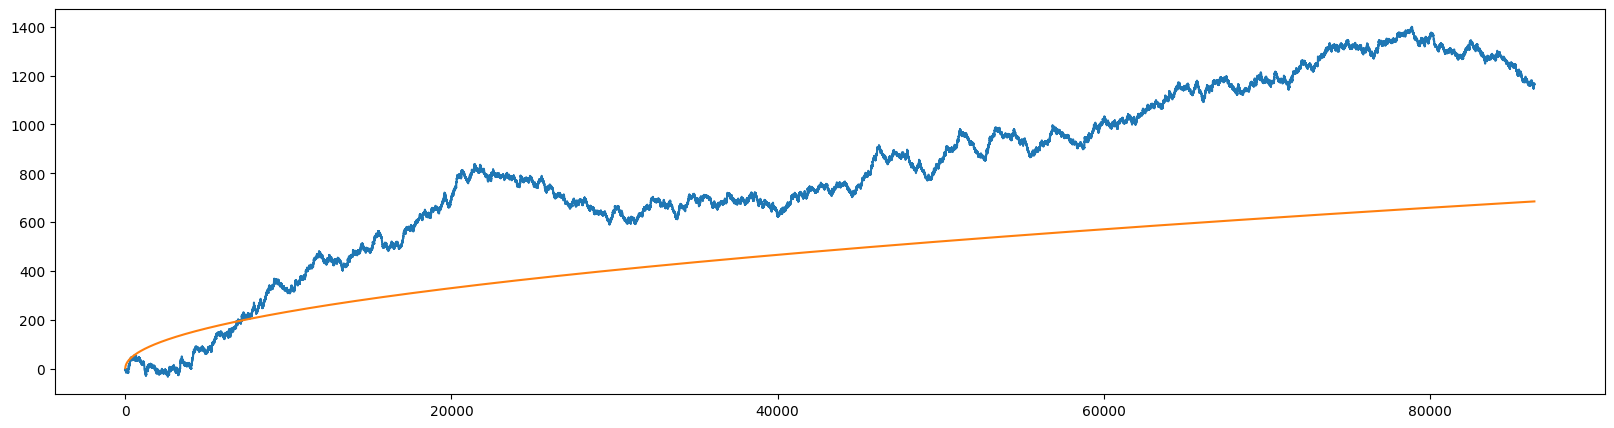

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import scipy
#data for a top-ranked GCP event - Valentine's day 2009
# Compare to: https://global-mind.org/valentines.09.html
idx=278
print(included_events[idx])

start_datetime, end_datetime = included_events[idx][2], included_events[idx][3]
event_data = gcp_data_reader.fetch_data(start_datetime, end_datetime, normalize=False)[0]

#make the chi-squared-minus-1 plot
csm1 = np.square(np.nansum((event_data - 100)/np.sqrt(50), axis=1)/np.sqrt(
        np.sum(np.isnan(event_data)==False, axis=1))) - 1
plt.figure(figsize=(20,5))
plt.plot(np.arange(len(csm1)), np.cumsum(csm1))
#also plot the p=0.05 envelop
plt.plot(np.arange(len(csm1)), np.array([scipy.stats.chi2.ppf(0.95, x+1)
                                         for x in np.arange(len(csm1))])
                                        - (np.arange(len(csm1))+1) )
plt.show()

Do aggregate analysis

In [14]:
from datetime import datetime,timedelta
import numpy as np
import h5py
import traceback
import scipy


def compute_pvaltoz(egg_values):

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row
  egg_zscores = (egg_values - 100)/np.sqrt(50)
  composite_z_scores = np.nansum(egg_zscores, axis=1)/np.sqrt(num_nonnan_eggs)

  pvaltoz_sumthensquare = scipy.stats.norm.ppf(
      scipy.stats.chi2.cdf(x=np.nansum(np.square(composite_z_scores)),
                           df=np.sum(np.isnan(composite_z_scores)==False)))
  pvaltoz_squarethensum = scipy.stats.norm.ppf(
      scipy.stats.chi2.cdf(np.nansum(np.square(egg_zscores)),
                           df=np.sum(np.isnan(egg_zscores)==False)))

  return pvaltoz_sumthensquare, pvaltoz_squarethensum

NORMALIZE = False

control_timeshifts = [-2, 2] #how much to shift the events by (as a multiple of their duration) to define 'control' time periods

surviving_events = [] #in case we encounter missing data errors, maintain a list of surviving events

eventcount = 0

allevents_pvaltozs_sumthensquare = []
allevents_pvaltozs_squarethensum = []
controls_pvaltozs_sumthensquare = defaultdict(list)
controls_pvaltozs_squarethensum = defaultdict(list)

missing_data_errors = []

for (event_num, event_name, start_datetime, end_datetime, duration) in included_events[:]:
  eventcount += 1
  print("EVENT COUNT", eventcount)
  print(event_num, event_name, start_datetime, end_datetime, duration)
  try:
    event_data = gcp_data_reader.fetch_data(start_datetime, end_datetime, normalize=NORMALIZE)[0]
    event_pvaltoz_sumthensquare, event_pvaltoz_squarethensum = compute_pvaltoz(event_data)
    print("Event data: Sum then square:", event_pvaltoz_sumthensquare)
    print("Event data: Square then sum:", event_pvaltoz_squarethensum)

    print("For controls...")
    thisevent_control_pvaltozs_sumthensquare = {}
    thisevent_control_pvaltozs_squarethensum = {}
    for control_timeshift in control_timeshifts:
      timeshift = timedelta(seconds=control_timeshift*duration)
      control_starttime = start_datetime + timeshift
      control_endtime = end_datetime + timeshift
      print("Control start and end:", control_starttime, control_endtime)
      control_data = gcp_data_reader.fetch_data(control_starttime, control_endtime, normalize=NORMALIZE)[0]
      pvaltozs_sumthensquare, pvaltozs_squarethensum = compute_pvaltoz(control_data)
      print("Control data: Sum then square:", pvaltozs_sumthensquare)
      print("Control data: Square then sum:", pvaltozs_squarethensum)
      thisevent_control_pvaltozs_sumthensquare[control_timeshift] = pvaltozs_sumthensquare
      thisevent_control_pvaltozs_squarethensum[control_timeshift] = pvaltozs_squarethensum

    allevents_pvaltozs_sumthensquare.append(event_pvaltoz_sumthensquare)
    allevents_pvaltozs_squarethensum.append(event_pvaltoz_squarethensum)
    for control_timeshift in control_timeshifts:
      controls_pvaltozs_sumthensquare[control_timeshift].append(
          thisevent_control_pvaltozs_sumthensquare[control_timeshift])
      controls_pvaltozs_squarethensum[control_timeshift].append(
          thisevent_control_pvaltozs_squarethensum[control_timeshift])
    surviving_events.append((event_num, event_name, start_datetime, end_datetime, duration))
  except GCPMissingDataError as e:
    print("MISSING DATA ERROR!",e)
    missing_data_errors.append(e)


Streaming output truncated to the last 5000 lines.
Found 'rotten egg' entries for device id: 28 in time range 2001-05-20 01:30:00 to 2001-05-20 03:59:59 (range: 2001-02-20 00:00:00 to 2001-05-30 23:59:59 )
After masking, fraction of nans in raw data is 0.03125
Event data: Sum then square: 0.5380547157971747
Event data: Square then sum: 0.604908921274308
For controls...
Control start and end: 2001-05-19 20:30:00 2001-05-19 22:59:59
Before masking, fraction of nans in raw data is 0.031322916666666666 for 2001-05-19 20:30:00 to 2001-05-19 22:59:59
Found 'rotten egg' entries for device id: 28 in time range 2001-05-19 20:30:00 to 2001-05-19 22:59:59 (range: 2001-02-20 00:00:00 to 2001-05-30 23:59:59 )
After masking, fraction of nans in raw data is 0.06257291666666667
Control data: Sum then square: 0.16149531574408194
Control data: Square then sum: -0.7300707538350865
Control start and end: 2001-05-20 06:30:00 2001-05-20 08:59:59
Before masking, fraction of nans in raw data is 6.944444444444

num events after dropping events with missing data: 490
************TIME PERIODS: actual
Meta-analysis Z-score if squaring *after* summing: 6.6240908012758855 pval: 1.7469581337081763e-11
Meta-analysis Z-score if squaring *before* summing 6.634367647992761 pval:  1.6294854354725885e-11
Argmax event for square after summing: ('487', 'September 21', datetime.datetime(2014, 9, 21, 0, 0), datetime.datetime(2014, 9, 21, 23, 59, 59), 86400.0) 3.220190532336857
Argmax event for square before summing: ('271', 'Obama Acceptance 080828', datetime.datetime(2008, 8, 29, 2, 0), datetime.datetime(2008, 8, 29, 3, 59, 59), 7200.0) 3.693110187603022
Correlation between the two scores: PearsonRResult(statistic=0.08998792634832475, pvalue=0.04648958154279343)


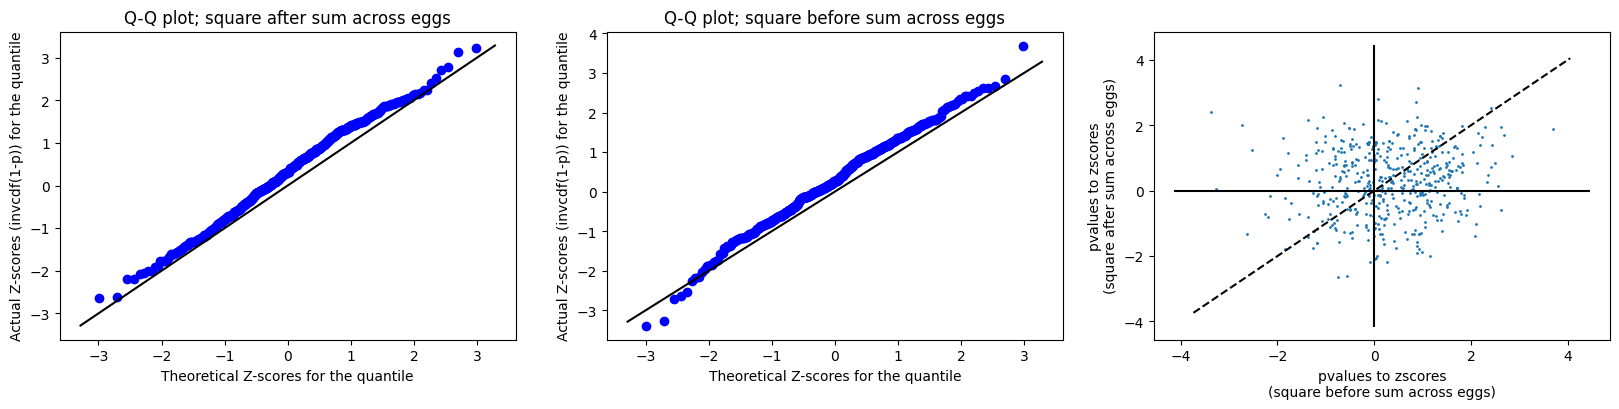

************TIME PERIODS: controltimeshift_-2
Meta-analysis Z-score if squaring *after* summing: 1.1423048153858648 pval: 0.12666367017879065
Meta-analysis Z-score if squaring *before* summing 7.811789634787452 pval:  2.7755575615628914e-15
Argmax event for square after summing: ('434', '12.12.12 Meditation', datetime.datetime(2012, 12, 12, 12, 30), datetime.datetime(2012, 12, 12, 15, 29, 59), 10800.0) 3.6758652241570964
Argmax event for square before summing: ('106', 'Tiger Woods Triumph', datetime.datetime(2002, 4, 14, 18, 22), datetime.datetime(2002, 4, 14, 22, 59, 59), 16680.0) 4.077320983912348
Correlation between the two scores: PearsonRResult(statistic=0.11554016408089125, pvalue=0.010478188761454687)


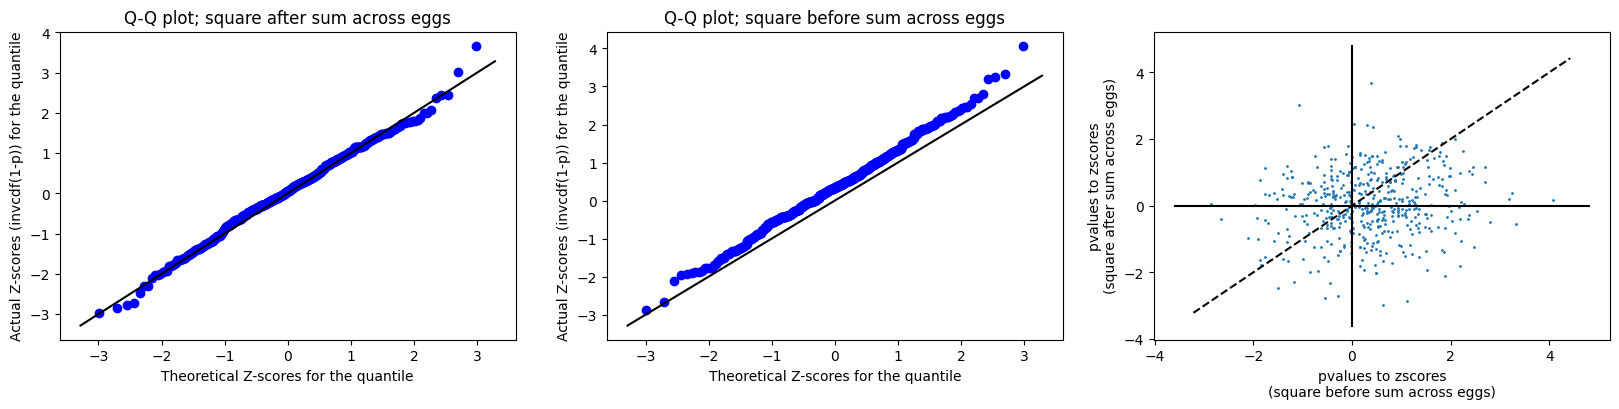

************TIME PERIODS: controltimeshift_2
Meta-analysis Z-score if squaring *after* summing: 0.06628893367500847 pval: 0.4735738967473425
Meta-analysis Z-score if squaring *before* summing 4.9217607622877475 pval:  4.2884511497476296e-07
Argmax event for square after summing: ('376', 'William &amp Catherine', datetime.datetime(2011, 4, 29, 10, 0), datetime.datetime(2011, 4, 29, 15, 59, 59), 21600.0) 3.7297312617661484
Argmax event for square before summing: ('100', 'Astrid Lindgren Dies', datetime.datetime(2002, 1, 28, 11, 0), datetime.datetime(2002, 1, 28, 14, 59, 59), 14400.0) 3.7399698663781185
Correlation between the two scores: PearsonRResult(statistic=0.18270702441976053, pvalue=4.7345653999002565e-05)


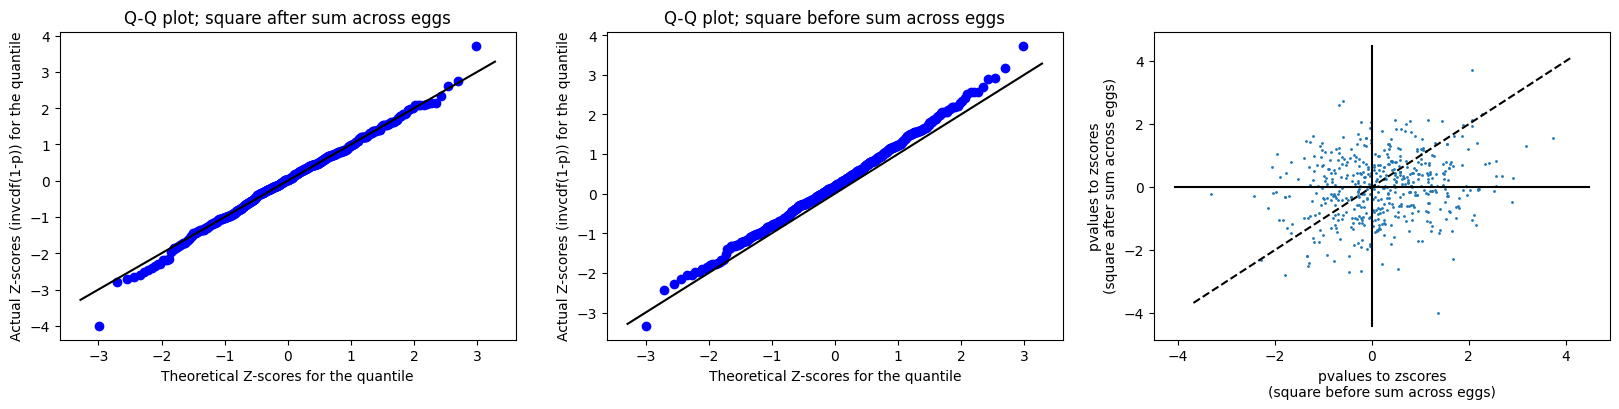

In [18]:
from matplotlib import pyplot as plt

print("num events after dropping events with missing data:", len(surviving_events))

for (touse_pvaltozs_sumthensquare, touse_pvaltozs_squarethensum, testtype) in (
    [ (allevents_pvaltozs_sumthensquare, allevents_pvaltozs_squarethensum, "actual")]
    +[ (controls_pvaltozs_sumthensquare[control_timeshift],
        controls_pvaltozs_squarethensum[control_timeshift],
        "controltimeshift_"+str(control_timeshift))
        for control_timeshift in control_timeshifts ]):

  print("************TIME PERIODS:", testtype)

  pvaltoz_sumthensquare = np.array(touse_pvaltozs_sumthensquare)
  pvaltoz_squarethensum = np.array(touse_pvaltozs_squarethensum)

  metaz_sumthensquare = np.sum(pvaltoz_sumthensquare)/np.sqrt(len(pvaltoz_sumthensquare))
  metaz_squarethensum = np.sum(pvaltoz_squarethensum)/np.sqrt(len(pvaltoz_squarethensum))
  print("Meta-analysis Z-score if squaring *after* summing:", metaz_sumthensquare, "pval:", 1-scipy.stats.norm.cdf(metaz_sumthensquare))
  print("Meta-analysis Z-score if squaring *before* summing", metaz_squarethensum, "pval: ", 1-scipy.stats.norm.cdf(metaz_squarethensum))
  print("Argmax event for square after summing:", surviving_events[np.argmax(pvaltoz_sumthensquare)], np.max(pvaltoz_sumthensquare))
  print("Argmax event for square before summing:", surviving_events[np.argmax(pvaltoz_squarethensum)], np.max(pvaltoz_squarethensum))
  print("Correlation between the two scores:", scipy.stats.pearsonr(pvaltoz_squarethensum, pvaltoz_sumthensquare))

  fig, ax = plt.subplots(ncols=3, figsize=(20,4))
  plt.sca(ax[0])
  scipy.stats.probplot(pvaltoz_sumthensquare, dist=scipy.stats.norm, plot=plt, fit=False)
  plt.plot(plt.xlim(), plt.xlim(), color="black")
  plt.title("Q-Q plot; square after sum across eggs")
  plt.xlabel("Theoretical Z-scores for the quantile")
  plt.ylabel("Actual Z-scores (invcdf(1-p)) for the quantile")
  plt.sca(ax[1])
  scipy.stats.probplot(pvaltoz_squarethensum, dist=scipy.stats.norm, plot=plt, fit=False)
  plt.plot(plt.xlim(), plt.xlim(), color="black")
  plt.title("Q-Q plot; square before sum across eggs")
  plt.xlabel("Theoretical Z-scores for the quantile")
  plt.ylabel("Actual Z-scores (invcdf(1-p)) for the quantile")
  plt.sca(ax[2])
  plt.scatter(pvaltoz_squarethensum, pvaltoz_sumthensquare, s=1)
  plt.plot(plt.xlim(), plt.xlim(), color="black", linestyle="--")
  plt.plot(plt.xlim(), [0,0], color="black")
  plt.plot([0,0], plt.ylim(), color="black")
  plt.xlabel("pvalues to zscores\n(square before sum across eggs)")
  plt.ylabel("pvalues to zscores\n(square after sum across eggs)")
  plt.show()